# TensorFlow Core Learning Algorithms - Linear Regression
In this notebook we will walk through 4 fundemental machine learning algorithms. 
- Linear Regression
- Classification
- Clustering
- Hidden Markov Models

See https://colab.research.google.com/drive/15Cyy2H7nT40sGR7TBN5wBvgTd57mVKay


In [14]:

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

(0.0, 6.0, 0.0, 20.0)

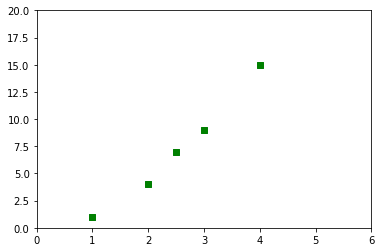

In [6]:
x = [1, 2, 2.5, 3, 4]
y = [1, 4, 7, 9, 15]
plt.plot(x, y, 'bx')  # Plot using Blue x marks
plt.axis([0, 6, 0, 20])

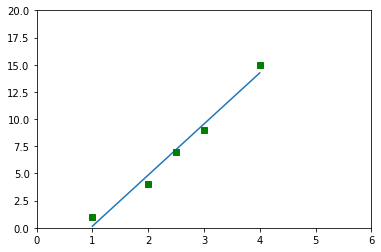

In [9]:
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.plot(x, y, 'gs')  # Plot using Green square marks
plt.axis([0, 6, 0, 20])
plt.show()

In [10]:
np.unique(x)

array([1. , 2. , 2.5, 3. , 4. ])

In [12]:
np.poly1d(np.polyfit(x, y, 1))

poly1d([ 4.7 , -4.55])

In [13]:
np.poly1d(np.polyfit(x, y, 1))(np.unique(x))

array([ 0.15,  4.85,  7.2 ,  9.55, 14.25])

### Training vs Testing Data
When we train models, we need two sets of data: **training and testing**. 

The **training** data is what we feed to the model so that it can develop and learn. It is usually a much larger size than the testing data.

The **testing** data is what we use to evaulate the model and see how well it is performing. We must use a seperate set of data that the model has not been trained on to evaluate it.

In [19]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data

In [20]:
dftrain.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [21]:
dftrain.describe()

,survived,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000,627.000000
mean,0.387560,29.631308,0.545455,0.379585,34.385399
std,0.487582,12.511818,1.151090,0.792999,54.597730
min,0.000000,0.750000,0.000000,0.000000,0.000000
25%,0.000000,23.000000,0.000000,0.000000,7.895800
50%,0.000000,28.000000,0.000000,0.000000,15.045800
75%,1.000000,35.000000,1.000000,0.000000,31.387500
max,1.000000,80.000000,8.000000,5.000000,512.329200


In [22]:
dftrain.shape

(627, 10)

In [23]:
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [24]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [25]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

<AxesSubplot:>

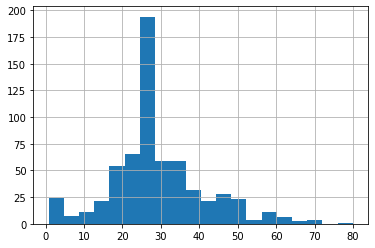

In [28]:
dftrain.age.hist(bins=20)

<AxesSubplot:>

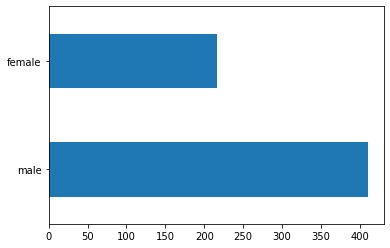

In [29]:
dftrain.sex.value_counts().plot(kind='barh')

In [30]:
dftrain.sex.value_counts()

male      410
female    217
Name: sex, dtype: int64

<AxesSubplot:>

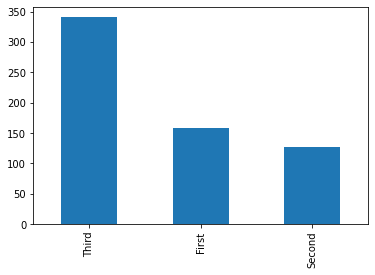

In [34]:
dftrain['class'].value_counts().plot(kind='bar')

<AxesSubplot:xlabel='age', ylabel='fare'>

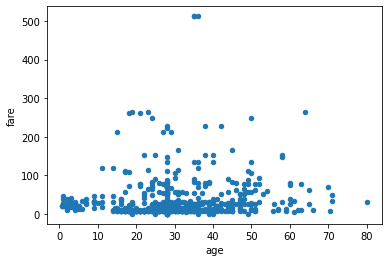

In [41]:
dftrain.plot.scatter("age", "fare")

<AxesSubplot:ylabel='class'>

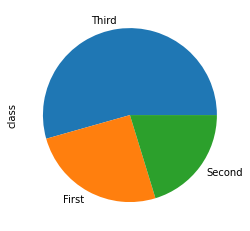

In [48]:
dftrain['class'].value_counts().plot.pie(y="fare")

### Feature Columns
In our dataset we have two different kinds of information: **Categorical and Numeric**

Our **categorical data** is anything that is not numeric! For example, the sex column does not use numbers, 
it uses the words "male" and "female".

Before we continue and create/train a model we must convet our categorical data into numeric data. We can 
do this by encoding each category with an integer (ex. male = 1, female = 2). 

Fortunately for us TensorFlow has some tools to help!

In [49]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

### Input Function
The TensorFlow model we are going to use requires that the data we pass it comes in as a ```tf.data.Dataset``` object. This means we must create a *input function* that can convert our current pandas dataframe into that object.

Below you'll see a seemingly complicated input function, this is straight from the TensorFlow documentation (https://www.tensorflow.org/tutorials/estimator/linear).

In [53]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  # inner function, this will be returned
  def input_function():
    # create tf.data.Dataset object with data and its label
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      # randomize order of data
      ds = ds.shuffle(1000)
    # split dataset into batches of 32 and repeat process for number of epochs
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

# here we will call the input_function that was returned to us to get a dataset object we can feed to the model
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


### Creating the Model
We are going to use a linear estimator to utilize the linear regression algorithm. 

In [55]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpwb3lbo43', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training the Model
Training the model is as easy as passing the input functions that we created earlier.

In [56]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on testing data

clear_output()  # clears console output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.75


In [57]:
print(result)

{'accuracy': 0.75, 'accuracy_baseline': 0.625, 'auc': 0.8341904, 'auc_precision_recall': 0.7842424, 'average_loss': 0.4869047, 'label/mean': 0.375, 'loss': 0.48050296, 'precision': 0.6460177, 'prediction/mean': 0.42223567, 'recall': 0.7373737, 'global_step': 200}


### Using the Model

Now let's see how we can actually use this model to make predicitons.

We can use the ```.predict()``` method to get survival probabilities from the model. This method will return a list of dicts that store a predicition for each of the entries in our testing data set.

As you can see the survival rate is not very high :/

In [59]:
pred_dicts = list(linear_est.predict(eval_input_fn))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpwb3lbo43/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

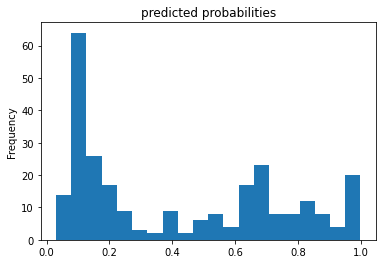

In [60]:
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')